In [2]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
words[:1]

['emma']

In [5]:
len(words)

32033

In [111]:
# build the vocabulary of characters and mappings to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [112]:
# build the dataset 
block_size = 3 # context length 

def build_dataset(words):
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

In [113]:
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [155]:
C = torch.randn((27, 2)) # lookup table with 27 rows and 2 columns

In [115]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [116]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [117]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [118]:
h

tensor([[ 0.9957, -0.6722, -0.9079,  ...,  0.9430,  0.7815,  0.9921],
        [ 0.9925, -0.8869, -0.8151,  ...,  0.9736,  0.4778,  0.9730],
        [ 0.9000, -0.9930, -0.4815,  ...,  0.9948, -0.8238,  0.3173],
        ...,
        [-0.9902, -0.9094,  0.9943,  ..., -0.3155, -0.6134, -0.9950],
        [ 0.1716, -0.9971,  0.9934,  ..., -0.4664, -0.9927, -0.9973],
        [-0.9970, -0.8298,  0.9469,  ...,  0.9763,  0.6266, -0.8954]])

In [119]:
h.shape

torch.Size([228146, 100])

In [120]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [121]:
logits = h @ W2 + b2

In [122]:
logits.shape

torch.Size([228146, 27])

In [123]:
counts = logits.exp()

In [124]:
prob = counts / counts.sum(1, keepdims=True)

In [125]:
prob.shape

torch.Size([228146, 27])

In [127]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
## Optimized implementation

In [128]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [129]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [131]:
sum(p.nelement() for p in parameters)

11897

In [132]:
for p in parameters:
    p.requires_grad = True

In [133]:
lre = torch.linspace(-2, 0, 1000)
lrs = 10**lre

In [134]:
lri = []
lossi = []
stepi = []

In [147]:
for i in range(100000):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])


    for p in parameters:
        p.grad = None 
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 10000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

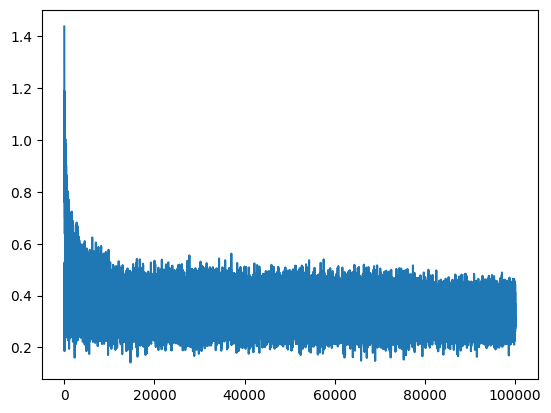

In [148]:
plt.plot(stepi, lossi)

In [149]:
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1929, grad_fn=<NllLossBackward0>)

In [150]:
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2168, grad_fn=<NllLossBackward0>)

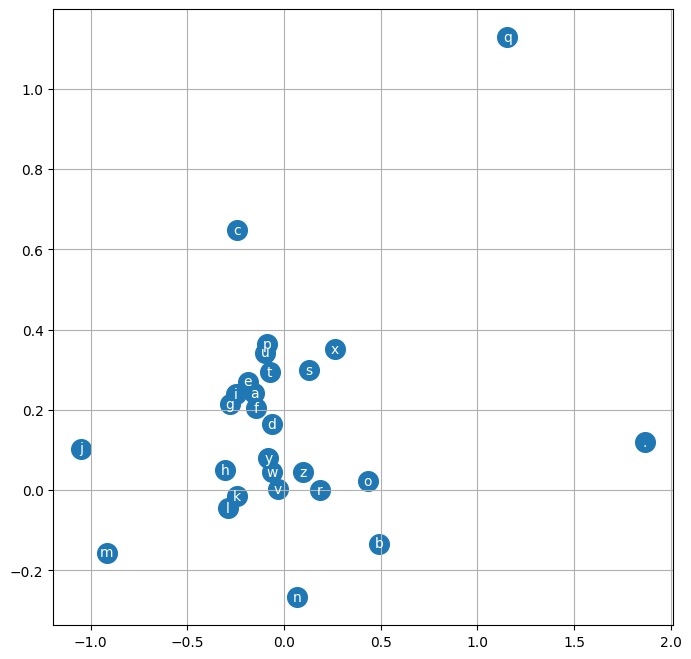

In [151]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [152]:
# training split, dev/validation split, test split 
# 80%, 10%, 10%

In [153]:
context = [0] * block_size 
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [154]:
# sample from the generator model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size 
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break 

    print(''.join(itos[i] for i in out))

mritaimyah.
seer.
ndyn.
alarethrcc.
jarlee.
aderedielin.
shy.
jenleigh.
van.
nar.
kayzion.
karin.
shibvon.
himier.
kindrenlynn.
nicolfoura.
avdir.
yaral.
ehs.
kayjahston.
